This example was adapted from skaae's Lasagne [recipe](https://github.com/skaae/Recipes/blob/spatial_transform/examples/spatial_transformer_network.ipynb).  
You can download skaae's Cluttered MNIST dataset [here](https://s3.amazonaws.com/lasagne/recipes/datasets/mnist_cluttered_60x60_6distortions.npz).

Reference at [arXiv](http://arxiv.org/abs/1506.02025)

In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import theano
np.random.seed(1337)  # for reproducibility

from scipy.misc import imresize

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.utils import np_utils, generic_utils
from keras.optimizers import Adam, SGD

from seya.layers.attention import DifferentiableRAM as DRAM

batch_size = 128
nb_classes = 10
nb_epoch = 12

DIM = 60
mnist_cluttered = "mnist_cluttered_60x60_6distortions.npz"

Using gpu device 0: GeForce GTX 680 (CNMeM is disabled)
Using Theano backend.


In [2]:
data = np.load(mnist_cluttered)
X_train, y_train = data['x_train'], np.argmax(data['y_train'], axis=-1)
X_valid, y_valid = data['x_valid'], np.argmax(data['y_valid'], axis=-1)
X_test, y_test = data['x_test'], np.argmax(data['y_test'], axis=-1)
# reshape for convolutions
X_train = X_train.reshape((X_train.shape[0], 1, DIM, DIM))
X_valid = X_valid.reshape((X_valid.shape[0], 1, DIM, DIM))
X_test = X_test.reshape((X_test.shape[0], 1, DIM, DIM))

y_train = np_utils.to_categorical(y_train, nb_classes)
y_valid = np_utils.to_categorical(y_valid, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

print("Train samples: {}".format(X_train.shape))
print("Validation samples: {}".format(X_valid.shape))
print("Test samples: {}".format(X_test.shape))

input_shape = X_train.shape[1:]

Train samples: (50000, 1, 60, 60)
Validation samples: (10000, 1, 60, 60)
Test samples: (10000, 1, 60, 60)


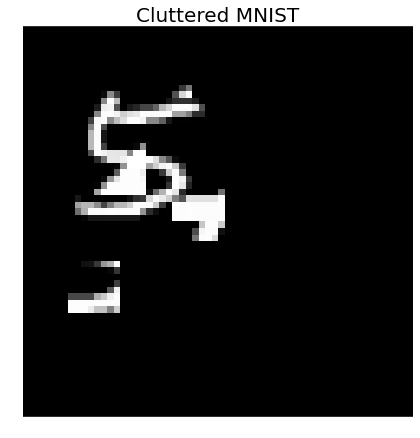

In [3]:
plt.figure(figsize=(7,7))
plt.imshow(X_train[101].reshape(DIM, DIM), cmap='gray', interpolation='none')
plt.title('Cluttered MNIST', fontsize=20)
plt.axis('off')
plt.show()

In [4]:
# initial weights
# The first two ones, force the attention to start in the middle of the image
# -1 forces the focus to start sharp
# last two zeros control distance between attention pixels in the input image and
# a image intensity scaling factor
b = np.asarray([1, 1, -1, 0., 0.]).astype('float32')
W = np.zeros((50, 5), dtype='float32')
weights = [W, 0*b.flatten()]

In [5]:
locnet = Sequential()
locnet.add(MaxPooling2D(pool_size=(2,2), input_shape=input_shape))
locnet.add(Convolution2D(20, 5, 5))
locnet.add(MaxPooling2D(pool_size=(2,2)))
locnet.add(Convolution2D(20, 5, 5))

locnet.add(Flatten())
locnet.add(Dense(50))
locnet.add(Activation('relu'))
locnet.add(Dense(5, weights=weights))
#locnet.add(Activation('sigmoid'))

In [6]:
model = Sequential()

model.add(DRAM(localization_net=locnet,
                             downsample_factor=3, input_shape=input_shape))

model.add(Convolution2D(32, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
XX = model.get_input()
YY = model.layers[0].get_output()
F = theano.function([XX], YY)

----------------------------------------
Epoch: 0 | Valid: 0.6913 | Test: 0.6898


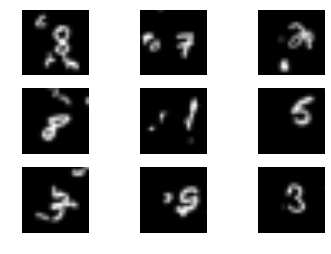

----------------------------------------
Epoch: 1 | Valid: 0.8177 | Test: 0.819
----------------------------------------
Epoch: 2 | Valid: 0.8493 | Test: 0.8512
----------------------------------------
Epoch: 3 | Valid: 0.8783 | Test: 0.8807
----------------------------------------
Epoch: 4 | Valid: 0.8939 | Test: 0.8977
----------------------------------------
Epoch: 5 | Valid: 0.8949 | Test: 0.8996


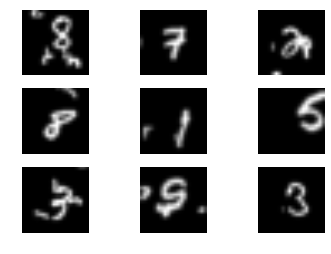

----------------------------------------
Epoch: 6 | Valid: 0.9104 | Test: 0.9147
----------------------------------------
Epoch: 7 | Valid: 0.9085 | Test: 0.9105
----------------------------------------
Epoch: 8 | Valid: 0.9218 | Test: 0.9261

In [ ]:
nb_epochs = 10 # you probably want to go longer than this
batch_size = 256
fig = plt.figure()
try:
    for e in range(nb_epochs):
        print('-'*40)
        #progbar = generic_utils.Progbar(X_train.shape[0])
        for b in range(X_train.shape[0]/batch_size):
            f = b * batch_size
            l = (b+1) * batch_size
            X_batch = X_train[f:l].astype('float32')
            y_batch = y_train[f:l].astype('float32')
            loss = model.train_on_batch(X_batch, y_batch)
            #progbar.add(X_batch.shape[0], values=[("train loss", loss)])
        scorev = model.evaluate(X_valid, y_valid, show_accuracy=True, verbose=0)[1]
        scoret = model.evaluate(X_test, y_test, show_accuracy=True, verbose=0)[1]
        print('Epoch: {0} | Valid: {1} | Test: {2}'.format(e, scorev, scoret))

        if e % 5 == 0:
            Xresult = F(X_batch[:9])
            plt.clf()
            for i in range(9):
                plt.subplot(3, 3, i+1)
                plt.imshow(Xresult[i, 0], cmap='gray')
                plt.axis('off')
            fig.canvas.draw()
            plt.show()
except KeyboardInterrupt:
    pass

### Visualizing what the Spatial Transformer learned

In [ ]:
Xaug = X_train[:9]
Xresult = F(Xaug.astype('float32'))

In [ ]:
# input
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(Xaug[i, 0], cmap='gray')
    plt.axis('off')

In [ ]:
# output
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(Xresult[i, 0], cmap='gray')
    plt.axis('off')